# Evaluation and submission analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the evaluation/racing data in a cleaner way, without the helper code which was moved into utility `.py` files.

**You will find this notebook most useful for race submissions reviews and because of that it is mostly focusing on this goal.**

## Usage

I am assuming here that you have already become familiar with `Training_analysis.ipynb`. Therefore descriptions that you will find here may be missing some bits if already described in there.

Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

**This notebook isn't complete.** What I find interesting in the logs may not be what you will find interesting and useful. I recommend you get familiar with the tools and try hacking around to get the insights that suit your needs.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Training environments

Depending on whether you're running your evaluations through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

For race submissions it is much more straightforward.

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io) for all the feedback about the notebooks. If you'd like, follow [my blog](https://codelikeamother.uk) where I tend to write about my experiences with AWS DeepRacer.

# Log Analysis

Let's get to it.

## Installs and setups

If you are using an AWS SageMaker Notebook to run the log analysis, you will need to ensure you install required dependencies. To do that uncomment and run the following:

In [1]:
# Make sure you have deepracer-utils >= 0.9

# import sys

# !{sys.executable} -m pip install --upgrade deepracer-utils

## Imports

Run the imports block below:

In [2]:
from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_meta

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu, \
    DeepRacerLog, \
    S3FileHandler, FSFileHandler, \
    LogType

import os

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Login

Login to AWS. There are several ways to log in:
1. On EC2 instance or Sagemaker Notebook with correct IAM execution role assigned.
2. AWS credentials available in `.aws/` through using the `aws configure` command. (DeepRacer-for-Cloud's `dr-start-loganalysis` supports this)
3. Setting the relevant environment variables by uncommenting the below section.

In [3]:
# os.environ["AWS_DEFAULT_REGION"] = "" #<-Add your region
# os.environ["AWS_ACCESS_KEY_ID"] = "" #<-Add your access key
# os.environ["AWS_SECRET_ACCESS_KEY"] = "" #<-Add you secret access key
# os.environ["AWS_SESSION_TOKEN"] = "" #<-Add your session key if you have one

## Load all race submission logs

**WARNING:** If you do not specify `not_older_than` parameter, all evaluation logs will be downloaded. They aren't as big as the training logs, but there is a lot of them.

That said you can download all and then it will only download new ones unless you use force=True.

There are also `not_older_than` and `older_than` parameters so you can choose to fetch all logs from a given period and compare them against each other. Just remember memory is finite.

As mentioned, this method always fetches a list of log streams and then downloads only ones that haven't been downloaded just yet. You can therefore use it to fetch that list and load all the files from the path provided.
## Get the logs

Depending on which way you are evaluating your model, you will need a slightly different way to load the data. The simplest way to read in evaluation data is using the sim-trace files.

For other ways to read in data look at the [configuration examples](https://github.com/aws-deepracer-community/deepracer-utils/blob/master/docs/examples.md)

In [4]:
PREFIX='Demo-Reinvent'      # Name of the model, without trailing '/'
BUCKET='deepracer-local'    # Bucket name is default 'bucket' when training locally
PROFILE=None                # The credentials profile in .aws - 'minio' for local training
S3_ENDPOINT_URL=None        # Endpoint URL: None for AWS S3, 'http://minio:9000' for local training

In [5]:
fh = S3FileHandler(bucket=BUCKET, prefix=PREFIX, profile=PROFILE, s3_endpoint_url=S3_ENDPOINT_URL)
log = DeepRacerLog(filehandler=fh)
log.load_evaluation_trace()

In [6]:
# # Example / Alternative for logs on file-system
# fh = FSFileHandler(model_folder='logs/sample-console-logs')
# log = DeepRacerLog(filehandler=fh)
# log.load_robomaker_logs(type=LogType.EVALUATION)

In [7]:
df = log.dataframe()

## Load waypoints for the track you want to run analysis on
The track waypoint files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below.

The naming of the tracks is not super consistent. The ones that we already know have been mapped to their official names in the track_meta dictionary.

Some npy files have an 'Eval' suffix. One of the challenges in the past was that the evaluation tracks were different to physical tracks and we have recreated them to enable evaluation. Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [8]:
!ls tracks/

tu = TrackIO()

for track in tu.get_tracks():
    print("{} - {}".format(track, track_meta.get(track[:-4], "I don't know")))

2022_april_open_ccw.npy		Belille.npy
2022_april_open_cw.npy		Bowtie_track.npy
2022_april_open.npy		caecer_gp.npy
2022_april_pro_ccw.npy		caecer_loop.npy
2022_april_pro_cw.npy		Canada_Eval.npy
2022_april_pro.npy		Canada_Training.npy
2022_august_open_ccw.npy	China_eval_track.npy
2022_august_open_cw.npy		China_track.npy
2022_august_open.npy		dubai_open_ccw.npy
2022_august_pro_ccw.npy		dubai_open_cw.npy
2022_august_pro_cw.npy		dubai_open.npy
2022_august_pro.npy		dubai_pro.npy
2022_july_open.npy		FS_June2020.npy
2022_july_pro_ccw.npy		hamption_open.npy
2022_july_pro_cw.npy		hamption_pro.npy
2022_july_pro.npy		H_track.npy
2022_june_open_ccw.npy		July_2020.npy
2022_june_open_cw.npy		jyllandsringen_open_ccw.npy
2022_june_open.npy		jyllandsringen_open_cw.npy
2022_june_pro_ccw.npy		jyllandsringen_open.npy
2022_june_pro_cw.npy		jyllandsringen_pro_ccw.npy
2022_june_pro.npy		jyllandsringen_pro_cw.npy
2022_march_open_ccw.npy		jyllandsringen_pro.npy
2022_march_open_cw.npy		LGSWide.npy
2022_march_open

Now let's load the track:

Loaded 119 waypoints


<Axes: >

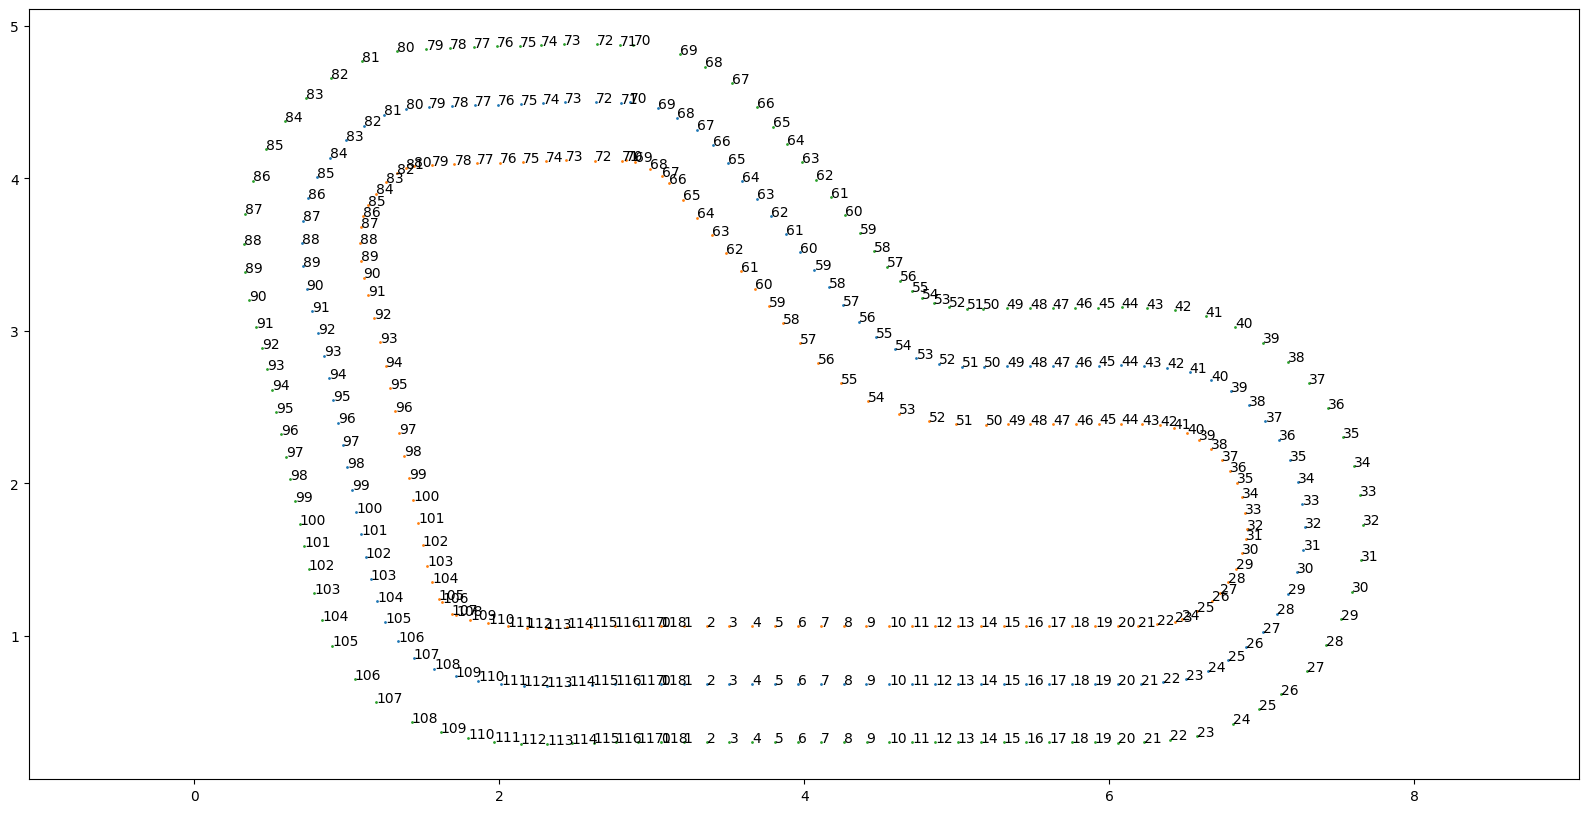

In [9]:
# We will try to guess the track name first, if it 
# fails, we'll use the constant in quotes

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    track_name = "reinvent_base"


track: Track = tu.load_track(track_name)

pu.plot_trackpoints(track)

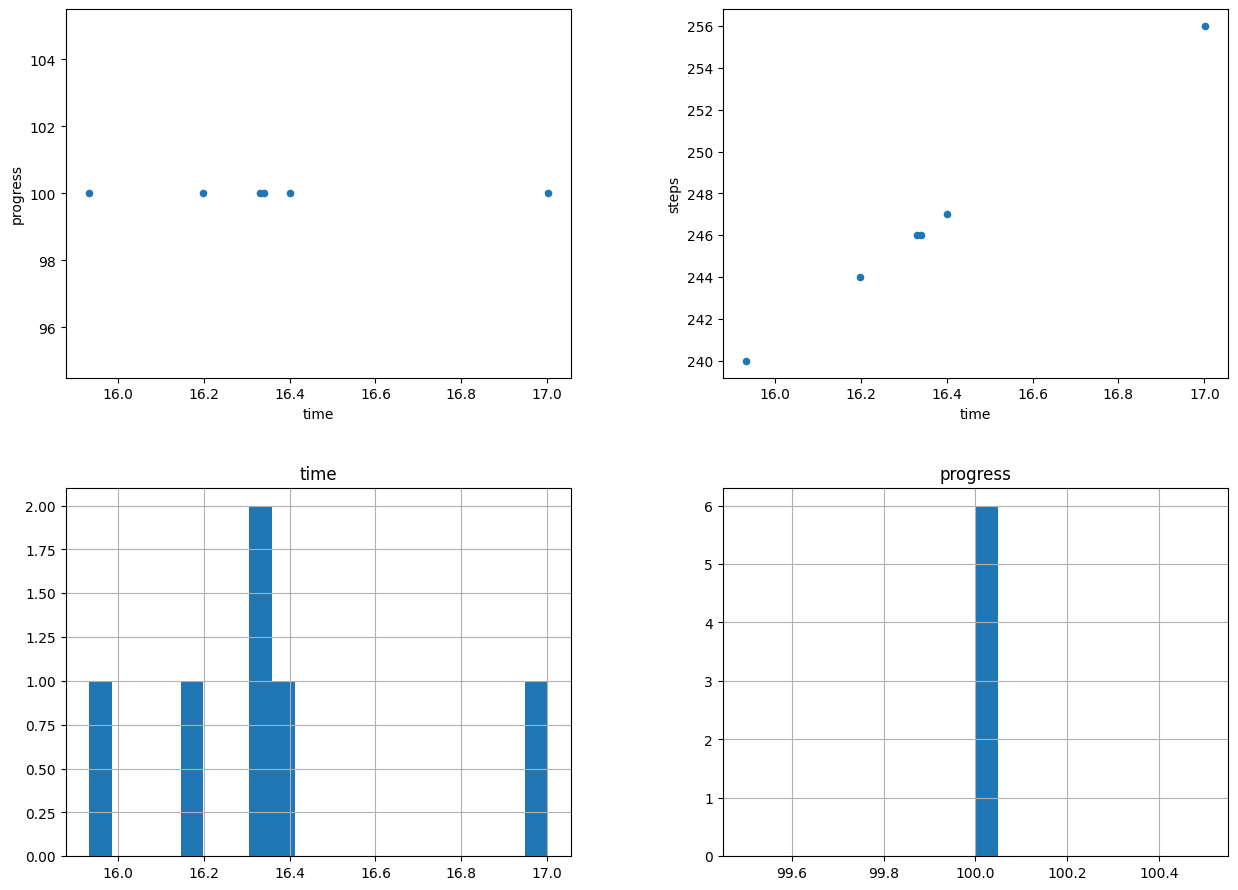

<Figure size 640x480 with 0 Axes>

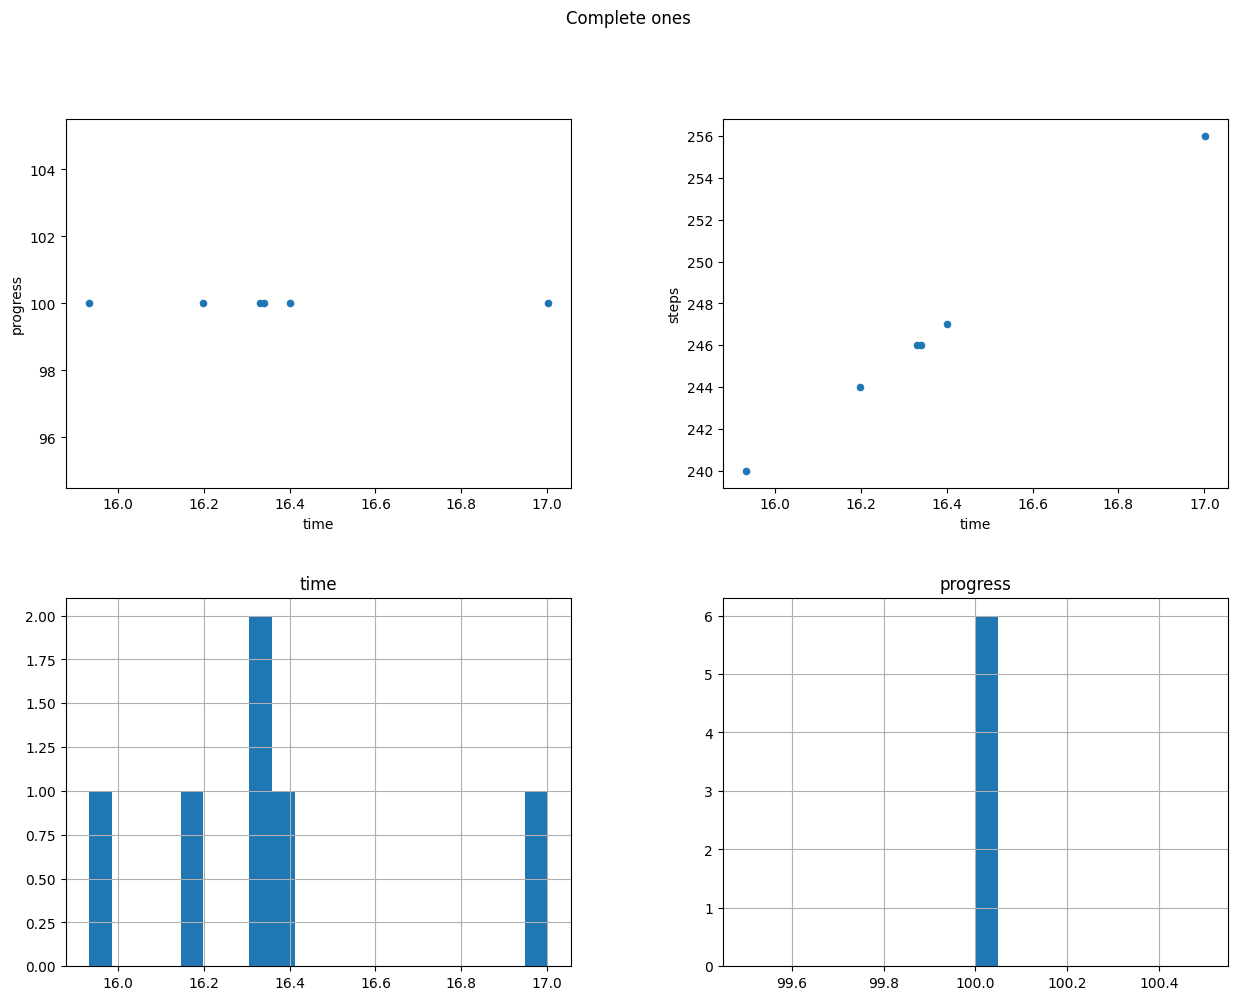

<Figure size 640x480 with 0 Axes>

In [10]:
simulation_agg = au.simulation_agg(df, 'stream', is_eval=True)
complete_ones = simulation_agg[simulation_agg['progress']==100]

# This gives the warning about ptp method deprecation. The code looks as if np.ptp was used, I don't know how to fix it.
au.scatter_aggregates(simulation_agg, is_eval=True)
if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, "Complete ones", is_eval=True)

## Data in tables

In [11]:
# View fifteen most progressed attempts
simulation_agg.nlargest(15, 'progress')

,stream,episode,steps,start_at,progress,time,dist,speed,crashed,off_track,time_if_complete,complete
0,20220612082853,0,247,1,100.0,16.401,17.637690,1.048583,0,0,16.401,1
1,20220612082853,1,244,1,100.0,16.199,17.675459,1.065574,0,0,16.199,1
2,20220612082853,2,246,1,100.0,16.340,17.618514,1.044715,0,0,16.340,1
3,20220612083839,0,240,1,100.0,15.932,17.183059,1.050000,0,0,15.932,1
4,20220612083839,1,256,1,100.0,17.002,17.563597,1.011719,0,0,17.002,1
5,20220612083839,2,246,1,100.0,16.330,17.530800,1.056911,0,0,16.330,1


In [12]:
# View fifteen fastest complete laps
complete_ones.nsmallest(15, 'time')

,stream,episode,steps,start_at,progress,time,dist,speed,crashed,off_track,time_if_complete,complete
3,20220612083839,0,240,1,100.0,15.932,17.183059,1.050000,0,0,15.932,1
1,20220612082853,1,244,1,100.0,16.199,17.675459,1.065574,0,0,16.199,1
5,20220612083839,2,246,1,100.0,16.330,17.530800,1.056911,0,0,16.330,1
2,20220612082853,2,246,1,100.0,16.340,17.618514,1.044715,0,0,16.340,1
0,20220612082853,0,247,1,100.0,16.401,17.637690,1.048583,0,0,16.401,1
4,20220612083839,1,256,1,100.0,17.002,17.563597,1.011719,0,0,17.002,1


## Plot all the evaluation laps

The method below plots your evaluation attempts. Just note that that is a time consuming operation and therefore I suggest using `min_distance_to_plot` to just plot some of them.

If you would like to, in a below section of this article you can load a single log file to evaluate this.

In the example below training track data was used for plotting the borders. Since then the community has put a lot of effort into preparing files that resemble the racing ones.

If you want to plot a single lap, scroll down for an example which lets you do a couple more tricks.

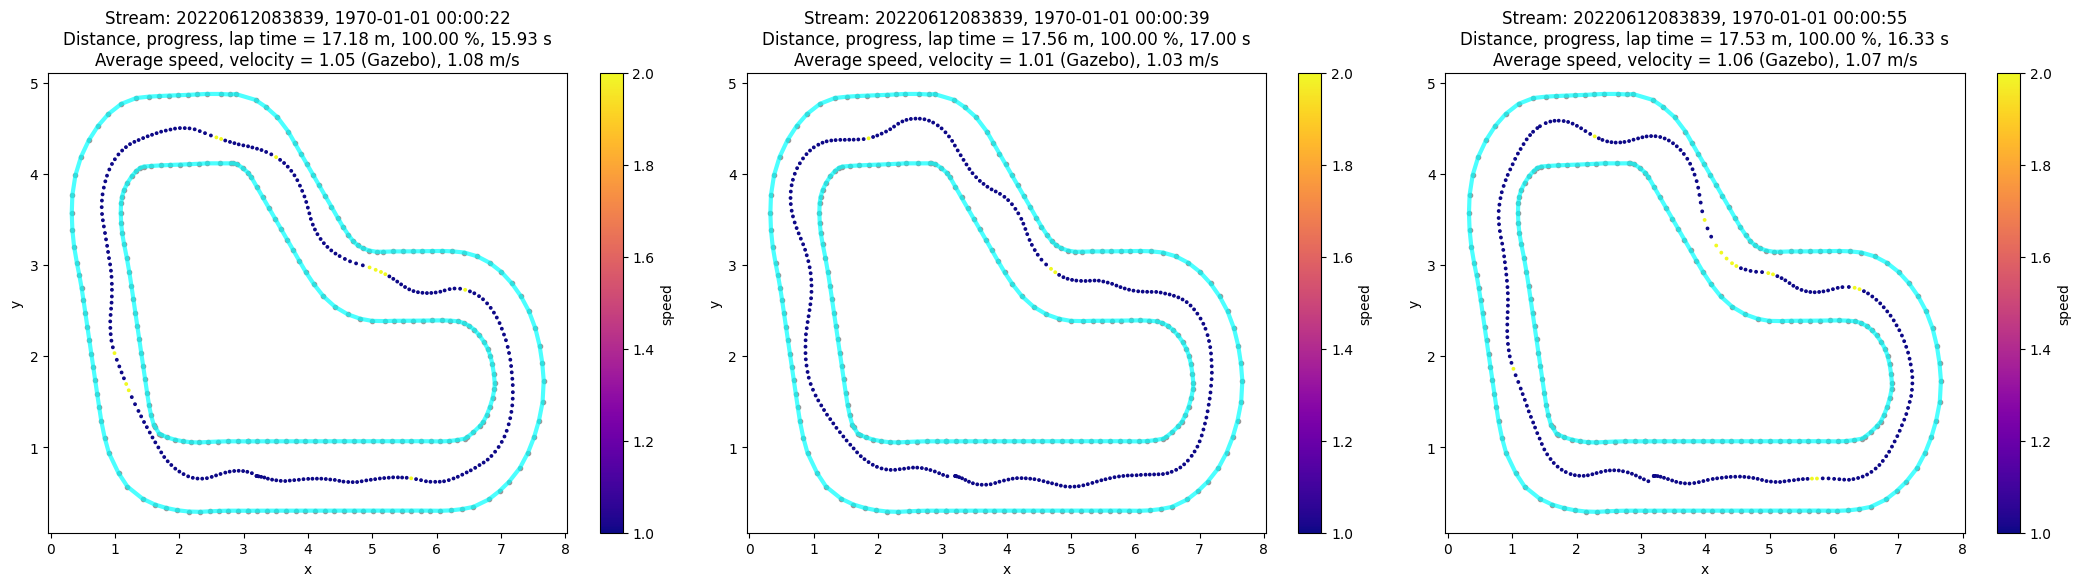

<Figure size 640x480 with 0 Axes>

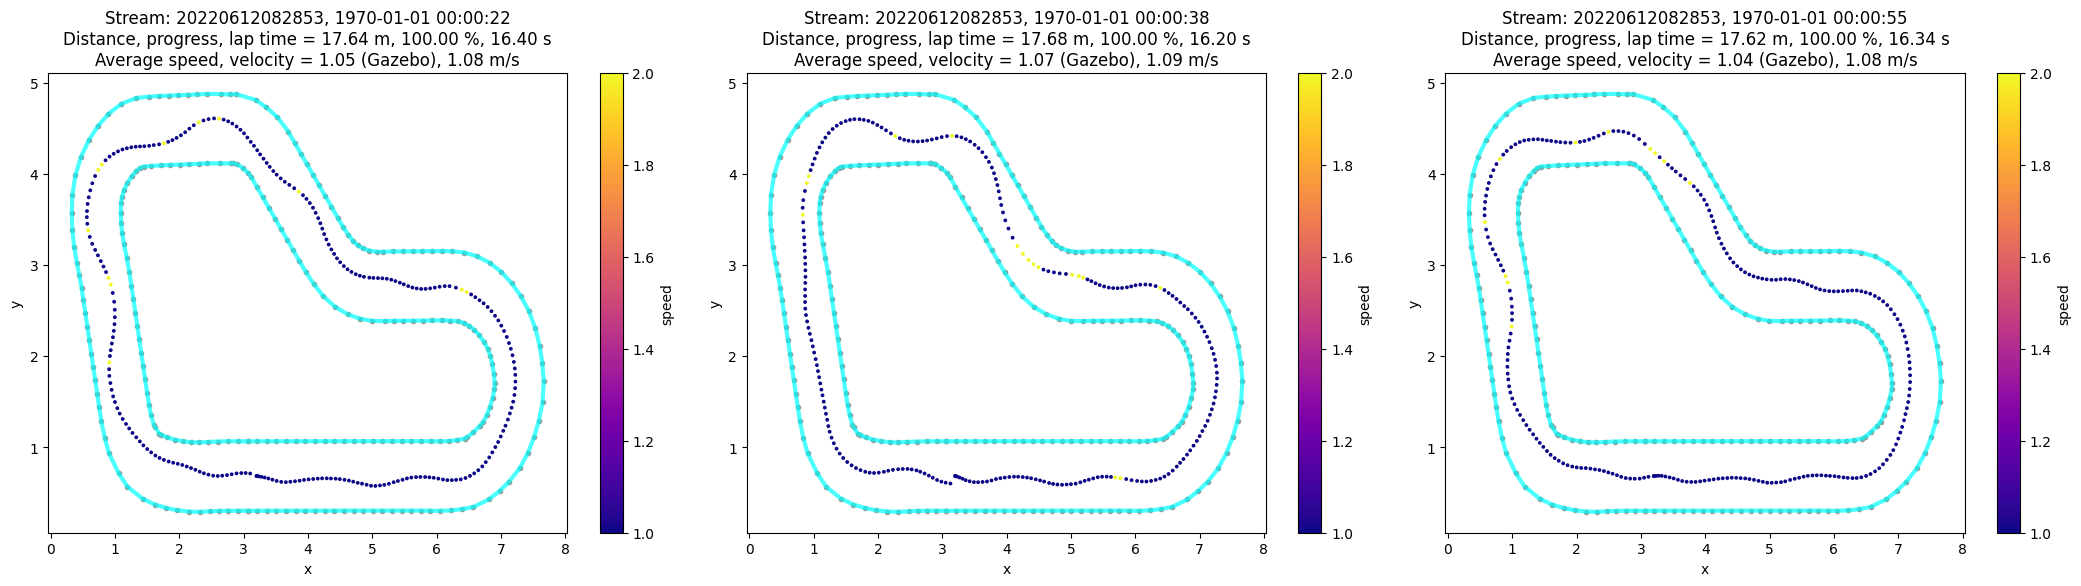

<Figure size 640x480 with 0 Axes>

In [13]:
pu.plot_evaluations(df, track)

## Single lap
Below you will find some ideas of looking at a single evaluation lap. You may be interested in a specific part of it. This isn't very robust but can work as a starting point. Please submit your ideas for analysis.

This place is a great chance to learn more about [Pandas](https://pandas.pydata.org/pandas-docs/stable/) and about how to process data series.

In [14]:
# Load a single lap
fastest = complete_ones.nsmallest(1, 'time')[['stream','episode']][0:1]
lap_df = df[(df['episode']==fastest.iloc[0,1]) & (df['stream']==fastest.iloc[0,0])]

We're adding a lot of columns here to the episode. To speed things up, it's only done per a single episode, so others will currently be missing this information.

Now try using them as a `graphed_value` parameter.

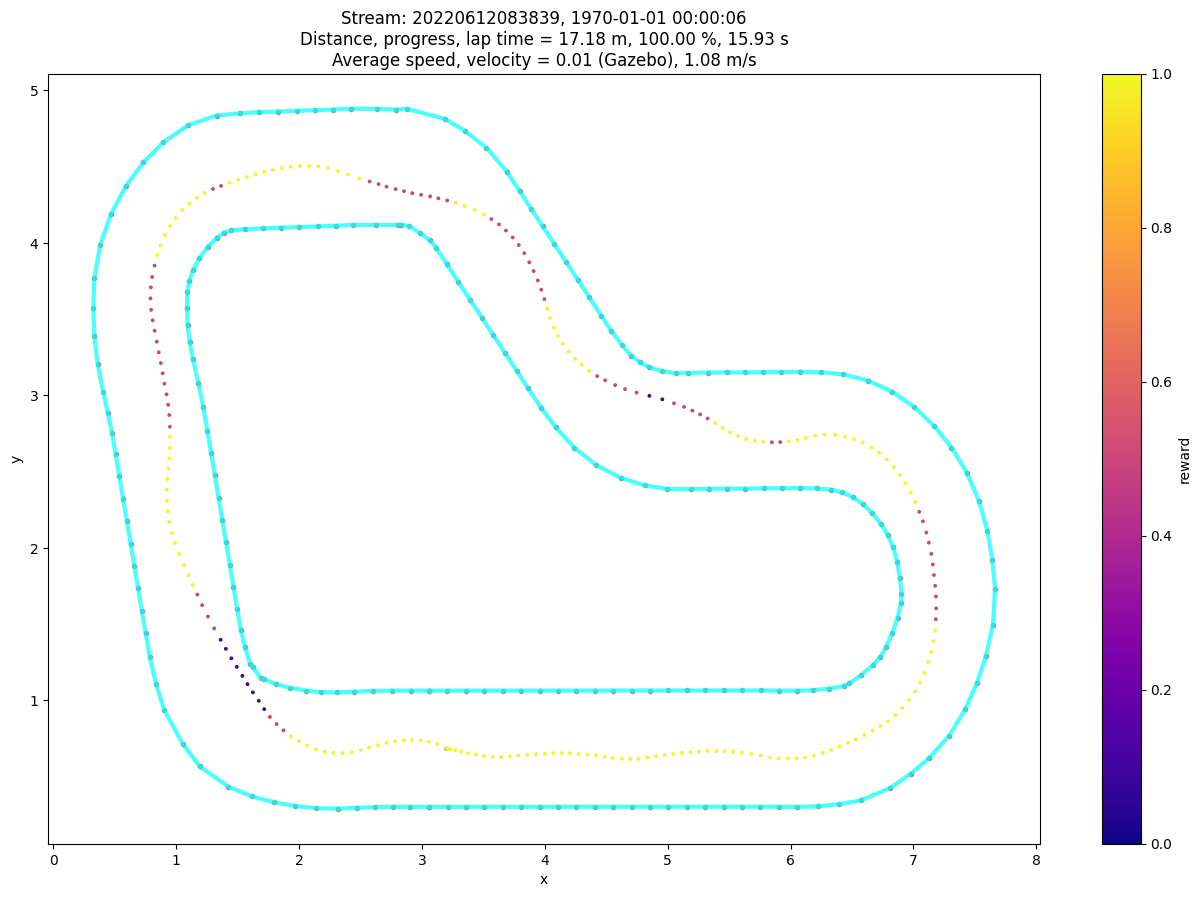

<Figure size 640x480 with 0 Axes>

In [15]:
lap_df.loc[:,'distance']=((lap_df['x'].shift(1)-lap_df['x']) ** 2 + (lap_df['y'].shift(1)-lap_df['y']) ** 2) ** 0.5
lap_df.loc[:,'time']=lap_df['tstamp'].astype(float)-lap_df['tstamp'].shift(1).astype(float)
lap_df.loc[:,'speed']=lap_df['distance']/(100*lap_df['time'])
lap_df.loc[:,'acceleration']=(lap_df['distance']-lap_df['distance'].shift(1))/lap_df['time']
lap_df.loc[:,'progress_delta']=lap_df['progress'].astype(float)-lap_df['progress'].shift(1).astype(float)
lap_df.loc[:,'progress_delta_per_time']=lap_df['progress_delta']/lap_df['time']

pu.plot_grid_world(lap_df, track, graphed_value='reward')